<a href="https://colab.research.google.com/github/bwsi-hadr/07-satellite-image-processing-dylan-pham/blob/master/07b_Integrating_raster_and_vector_GIS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrating raster and vector GIS data
We've now had experience working with both raster and vector GIS data individually. Now we'll look into how to integrate the two data types.



In [1]:
# need to specify location of some certificates for rasterio
!export CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt
!sudo mkdir -p /etc/pki/tls/certs
!sudo cp /etc/ssl/certs/ca-certificates.crt /etc/pki/tls/certs/ca-bundle.crt
try:
  import rasterio
  import rasterio.plot
  import rasterio.merge 
  import rasterio.mask
except:
  !pip install rasterio
  import rasterio
  import rasterio.plot
  import rasterio.merge
  import rasterio.mask
  
try:
  import rasterstats as rs
except:
  !pip install rasterstats  
  import rasterstats as rs
  
try:
  import pyproj
except:
  !pip install pyproj
  import pyproj
  
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

     |████████████████████████████████| 19.7MB 1.9MB/s 
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 17.9MB 8.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built simplejson munch
     |████████████████████████████████| 11.2MB 2.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 555 kB of archives.

## Loading landsat


In [2]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/021/030/LC08_L1TP_021030_20180702_20180716_01_T1/LC08_L1TP_021030_20180702_20180716_01_T1_B2.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)



Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7651, 'height': 7771, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(30.0, 0.0, 569685.0,
       0.0, -30.0, 4899915.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Getting topological raster data
We're going to get some elevation data from USGS. You can search for data products from USGS [here](https://viewer.nationalmap.gov/basic/#productGroupSearch). We are using elevation products (3DEP) at 1/3 arc-second (~10m) resolution. Each tile spans 1x1 degree.

The files are available as .zip of [Erdas Imagine .img](https://gdal.org/drivers/raster/hfa.html) filetypes. We'll be using the rasterio `zip+https://` [syntax](https://rasterio.readthedocs.io/en/stable/topics/datasets.html) to get the unzipped .img files from the url.

In [0]:
# Get raster of boston-area elevations (takes a while)
tile1_url = 'zip+https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n43w072_IMG.zip!USGS_NED_13_n43w072_IMG.img'
tile2_url = 'zip+https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n43w071_IMG.zip!USGS_NED_13_n43w071_IMG.img'

# we'll write them to local files so we don't have to keep downloading
local_tile1_location = 'local_tile1.tif'
local_tile2_location = 'local_tile2.tif'

We'll write a local copy so we don't have to keep downloading

In [0]:
def download_to_local(tile_url, local_tile_path):
  with rasterio.Env():
    with rasterio.open(tile_url) as src:
      profile = src.profile
      profile['dtype'] = 'float64'
      profile['indexes'] = 1
      print(profile)
      with rasterio.open(local_tile_path, 'w', **profile) as dst:
        dst.write_band(1,src.read(1).squeeze().astype(np.float64))

In [5]:
download_to_local(tile1_url, local_tile1_location)

{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584582e-05, 0.0, -72.00055555519407,
       0.0, -9.259259252584582e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True, 'indexes': 1}


In [6]:
download_to_local(tile2_url, local_tile2_location)

{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584581e-05, 0.0, -71.00055555539387,
       0.0, -9.259259252584581e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True, 'indexes': 1}


In [7]:
# the files are really big, so we'll open them at half resolution each
with rasterio.open(local_tile1_location) as src:
  print(src.profile)
  tile1 = src.read(1, out_shape=(int(src.height/2), int(src.width/2)), 
                   resampling=rasterio.enums.Resampling.bilinear)
  tile1_transform = src.profile['transform']
  
with rasterio.open(local_tile2_location) as src:
  print(src.profile)
  tile2 = src.read(1, out_shape=(int(src.height/2), int(src.width/2)), 
                   resampling=rasterio.enums.Resampling.bilinear)
  tile2_transform = src.profile['transform']
  

{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584582e-05, 0.0, -72.00055555519407,
       0.0, -9.259259252584582e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True}
{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584581e-05, 0.0, -71.00055555539387,
       0.0, -9.259259252584581e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True}


In [8]:
print(tile1.shape, tile2.shape)

(5406, 5406) (5406, 5406)


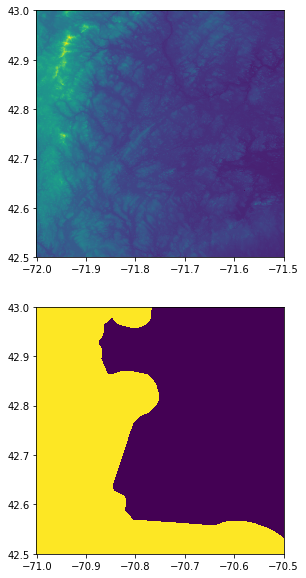

In [10]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(tile1, ax=ax1, transform=tile1_transform)
# fig.colorbar(p1, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(tile2, ax=ax2, transform=tile2_transform)
# fig.colorbar(p2, ax=ax2)


The second part looks weird, right? That's because it contains `nodata` values, which are `-3.4028234663853e+38`. That makes the low end way too low. 

Fortunately, there's a masking function that lest us select all of the non-nodata pixels

In [0]:
with rasterio.open(local_tile1_location) as src:
  tile1_mask = src.read_masks(1, out_shape=(int(src.height/2), int(src.width/2)), 
                   resampling=rasterio.enums.Resampling.bilinear)
  

with rasterio.open(local_tile2_location) as src:
  tile2_mask = src.read_masks(1, out_shape=(int(src.height/2), int(src.width/2)), 
                   resampling=rasterio.enums.Resampling.bilinear)
  


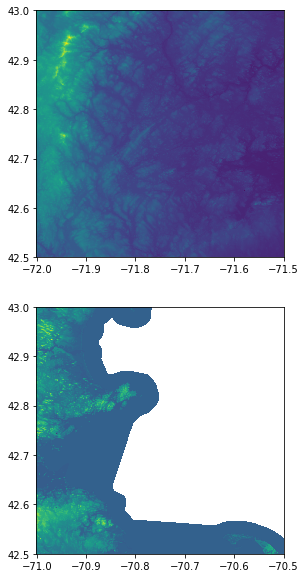

In [12]:
# we use the np.ma.masked_where() function to mask out all the values equal to zero
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(np.ma.masked_where(tile1_mask==0, tile1), ax=ax1, transform=tile1_transform)
# fig.colorbar(p1, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(np.ma.masked_where(tile2_mask==0, tile2), ax=ax2, transform=tile2_transform)
# fig.colorbar(p2, ax=ax2)


Let's combine the two tiles together into one large mosaic and save it as a geotiff

In [0]:
combined_location = 'combined.tif'

In [0]:
with rasterio.open(local_tile1_location, 'r') as src1:
  with rasterio.open(local_tile2_location, 'r') as src2:
    combined, out_transform = rasterio.merge.merge([src1, src2],
                                                   nodata=src2.profile['nodata'])
    combined_meta = src1.meta.copy()
    combined_meta.update({'driver':'GTiff',
                     'count': combined.shape[0],
                    'height': combined.shape[1],
                    'width': combined.shape[2],
                    'transform': out_transform,
                    'crs': src1.crs})
    with rasterio.open(combined_location, 'w', **combined_meta) as dst:
      dst.write(combined)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 21613, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584582e-05, 0.0, -72.00055555519407,
       0.0, -9.259259252584582e-05, 43.00055555489587)}


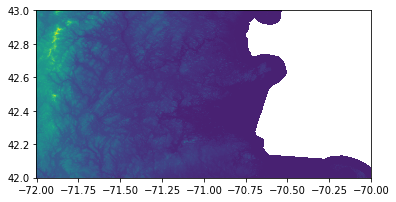

In [15]:
with rasterio.open(combined_location, 'r') as src:
  print(src.meta)
  combined = src.read(1)
  combined_mask = src.read_masks(1)
  combined_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                     transform=combined_transform)

In [0]:
camb_name = "Cambridge, MA, USA"
graph_area_cambridge = ox.gdf_from_place(camb_name)
bos_name = "Boston, MA, USA"
graph_area_bos = ox.gdf_from_place(bos_name)
local_areas = graph_area_bos.append(graph_area_cambridge, ignore_index=True)
local_areas.to_crs(epsg=4269).to_file('local_areas.shp')

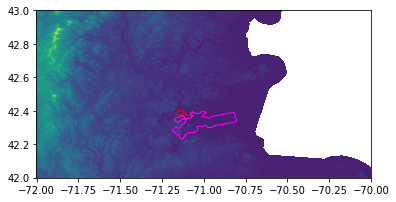

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
graph_area_cambridge.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
graph_area_bos.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='magenta')
plt.show()


In [0]:
rs.zonal_stats('local_areas.shp','combined.tif',stats='mean max')

[{'max': 101.32135772705078, 'mean': 9.42119953886361},
 {'max': 24.80925941467285, 'mean': 4.870253793586865}]